In [1]:
from classification import Setup, RoadData, RoadModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

In [2]:
setup = Setup('../images', '../annotations')
train_df = setup.generate_train_df()
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../images/road712.png,300,400,0,98,140,139,182,images_resized/road712.png,"[105.0, 98.0, 136.0, 138.0]"
1,../images/road706.png,300,400,0,136,92,177,135,images_resized/road706.png,"[69.0, 136.0, 101.0, 176.0]"
2,../images/road289.png,300,400,1,61,140,146,227,images_resized/road289.png,"[105.0, 61.0, 170.0, 145.0]"
3,../images/road538.png,300,400,0,115,169,149,205,images_resized/road538.png,"[126.0, 115.0, 153.0, 148.0]"
4,../images/road510.png,300,400,0,89,201,133,245,images_resized/road510.png,"[150.0, 89.0, 183.0, 132.0]"


(400, 300, 3)


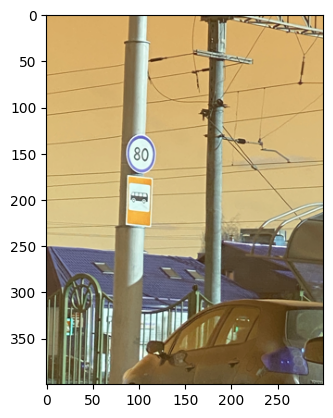

In [3]:
im, Y = setup.test_mask(58)
plt.imshow(im)

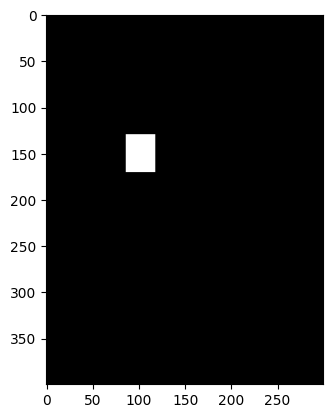

In [4]:
plt.imshow(Y, cmap="gray")

images_resized/road473.png


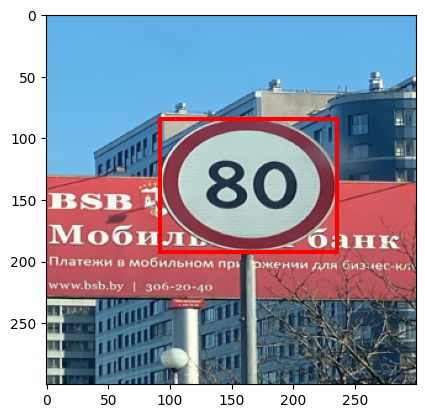

In [5]:
number = 60
setup.test_bb(number)

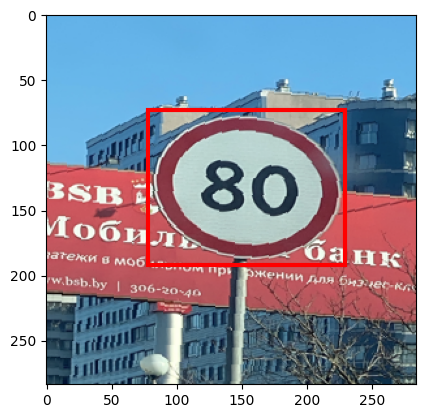

In [6]:
setup.test_transforms(number)

In [7]:
train_df = train_df.reset_index()
X = train_df[['new_path', 'new_bb']]
Y = train_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [8]:
train_ds = RoadData(X_train['new_path'], X_train['new_bb'], Y_train, setup, is_transforms=True)
valid_ds = RoadData(X_val['new_path'], X_val['new_bb'], Y_val, setup)

In [9]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def train(network, optimizer):
    network.train()
    total = 0
    sum_loss = 0
    
    for x, y_class, y_bb in train_dl:
        len_batch = y_class.shape[0]
        x = x.to(device).float()
        y_class = y_class.to(device)
        y_bb = y_bb.to(device).float()
        out_class, out_bb = network(x)
        
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
        loss = loss_class + loss_bb
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total += len_batch
        sum_loss += loss.item()
    
    train_loss = sum_loss / (total + 1e-6)
    return train_loss
        

In [11]:
def test(network):
    network.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()
            
            out_class, out_bb = network(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1) 
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
        
        val_loss = val_sum_loss / (val_total + 1e-6)
        val_acc = correct / (val_total + 1e-6)
        
        return val_acc
        

In [12]:
def objective(trial):
    net = trial.suggest_categorical("net", ["resnet34", "resnet50"])

    model = RoadModel(trial, net).to(device)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        train(model, optimizer)
        accuracy = test(model)
        
        trial.report(accuracy, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return accuracy

In [13]:
n_epochs = 15
number_of_trials = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=number_of_trials)

[I 2023-12-03 19:19:45,759] A new study created in memory with name: no-name-10f6e975-17d4-4706-abc7-4dc61bad9a33
